In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import math
import random
import collections
from keras.models import Sequential
from keras.layers import TimeDistributed,Dense,Activation,Layer,Input,Average,Concatenate,Conv2D,MaxPooling2D,Flatten,Lambda
from keras.models import Model,clone_model
from keras.optimizers import Adam
from copy import deepcopy
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
#demostration parameters
d = np.array([[0.6,-0.1],[0.5,-0.23],[0.4,-0.43],[-0.6,0.1],[-0.5,0.23],[-0.4,0.43]])
n_max=5

In [3]:
def demonstration(p, x, noise = 0):
    f = (math.exp(-x**2/(2.*d[p,0]**2))/(math.sqrt(2*math.pi)*d[p,0]))+d[p,1]
    return f+(noise*(random.random()-0.5)/100.)

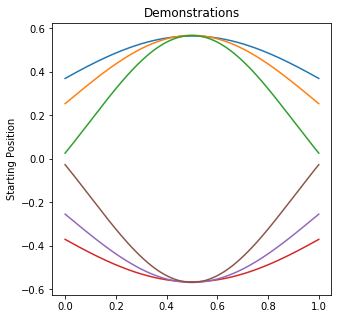

In [4]:
fig = plt.figure(figsize=(5,5))
x = np.linspace(-0.5,0.5,200)
times = x+0.5
y = np.zeros((6,200))
for p in range(6):
        for i in range(200):
            y[p,i] = demonstration(p,x[i])
        plt.plot(times, y[p])
plt.title('Demonstrations')
plt.ylabel('Starting Position')
plt.show()

In [5]:
def get_train_sample():
    observation = np.zeros((1,n_max,2))
    observation_flag = np.zeros((1,1,n_max))
    target = np.zeros((1,1,1))
    p = random.randint(0, 5)
    n = random.randint(1,n_max)
    perm = np.random.permutation(200)
    for i in range(n):
        observation[0,i] = [times[perm[i]],y[p,perm[i]]]
        observation_flag[0,0,i] = 1./n
    target[0,0,0] = times[perm[n]]
    return [observation,observation_flag,target], [[[y[p,perm[n]],0.]]],p

In [6]:
def test_plt_model(c_x,c_y):
    pred_y = np.zeros(200)
    pred_std = np.zeros(200)
    observation = np.zeros((1,n_max,2))
    observation_flag = np.zeros((1,1,n_max))
    target = np.zeros((1,1,1))
    observation[0,0] = [c_x,c_y]
    observation_flag[0,0,0] = 1.
    fig = plt.figure(figsize=(5,5))
    for i in range(200):
        target[0,0,0] = times[i]
        pred = model.predict([observation,observation_flag,target])[0][0]
        pred_std[i] = math.log(1+math.exp(pred[1]))
        pred_y[i] = pred[0]   
    for i in range(6):
        plt.plot(times,y[i])   
    plt.plot(times,pred_y,color='black')
    plt.errorbar(times,pred_y,yerr=pred_std,color = 'black',alpha=0.4)
    plt.scatter(c_x,c_y,marker="X",color='black')
    plt.show()        

In [7]:
def custom_loss(y_true, y_pred):
    mean, log_sigma = tf.split(y_pred, 2, axis=-1)
    y_target, temp =tf.split(y_true,2,axis=-1)
    sigma = tf.nn.softplus(log_sigma)
    dist = tfp.distributions.MultivariateNormalDiag(loc=mean, scale_diag=sigma)
    loss = -tf.reduce_mean(dist.log_prob(y_target))
    return loss

In [8]:
observation_layer = Input(shape=(n_max,2))
observation_flag_layer=Input(shape=(1,n_max)) 

observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_layer)
observation_encoded = TimeDistributed(Dense(128, activation='relu'))(observation_encoded)
observation_encoded = TimeDistributed(Dense(128))(observation_encoded)

matmul_layer=Lambda(lambda x:(tf.matmul(x[0],x[1])), output_shape =(1,128))

representation=matmul_layer([observation_flag_layer,observation_encoded])

target_layer = Input(shape=(1,1))

decoder_input = Concatenate(axis=2)([representation, target_layer])

decoder = Dense(128, activation='relu')(decoder_input)
decoder = Dense(128, activation='relu')(decoder)
output_layer = Dense(2)(decoder)

model = Model(inputs=[observation_layer,observation_flag_layer,target_layer],outputs=output_layer)
model.compile(optimizer = Adam(lr = 1e-4),loss=custom_loss)
model.summary()

representation_model = Model(inputs=[observation_layer,observation_flag_layer,target_layer],outputs=decoder_input)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 2)         0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 5, 128)       384         input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, 5, 128)       16512       time_distributed_1[0][0]         
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 5)         0                                            
__________________________________________________________________________________________________
time_distr

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

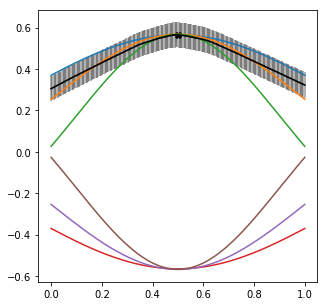

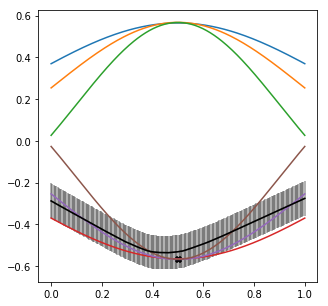

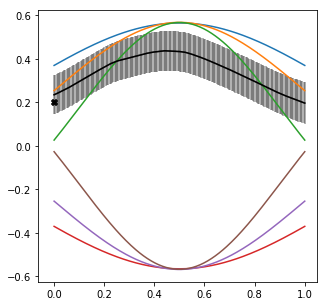

step 10000
loss -1.8326727151870728


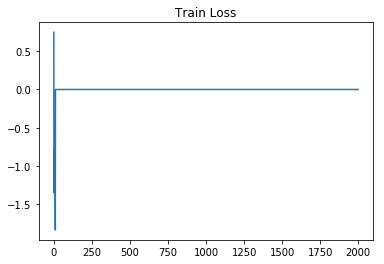

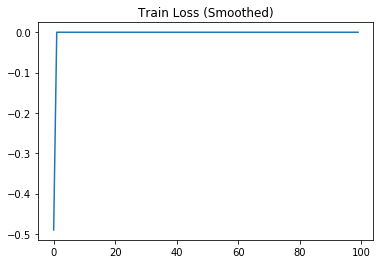

KeyboardInterrupt: 

In [9]:
import time
import pylab as pl
from IPython import display
training_loss = np.zeros(2000)
for step in range(2000000):
    inp,out,sample = get_train_sample()
    data = model.fit(inp,out,batch_size=1,verbose=0)
    if step % 1000 == 0:
        training_loss[step/1000] = data.history['loss'][0]
    if step % 10000 == 0:
        display.clear_output(wait=True)
        display.display(pl.gcf())
        inp,out,sample = get_train_sample()
        test_plt_model(c_x=0.5,c_y=0.5648)
        test_plt_model(c_x=0.5,c_y=-0.5648)
        test_plt_model(c_x=0.,c_y=0.2)
        print 'step', step
        print 'loss', data.history['loss'][0]
        plt.title('Train Loss')
        plt.plot(range(2000),training_loss)
        plt.show()
        mean_loss = np.zeros((100))
        for i in range(100):
            mean_loss[i] = np.mean(training_loss[i*20:(i+1)*20])
        fig = plt.figure()
        plt.title('Train Loss (Smoothed)')
        plt.plot(range(100),mean_loss)
        plt.show()